# Dinosaur challenge

Team Members: Sybren Backx, Ilias Leys, Bent Vermeiren

Image Classification Challenge - 'Artificial Intelligence' Course at Thomas More
In this team-based challenge, you will develop a deep learning model to classify images into 7 distinct dinosaur species. This project is part of the 'Artificial Intelligence' course at Thomas More, and focuses on applying TensorFlow/Keras for image classification.

# Exploratory Data Analysis (EDA)

In [89]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np


In [90]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir='./logs')

## Global variables

In [ ]:
MAX_EPOCH_RUN_1 = 8
MAX_EPOCH_RUN_2 = 8
BATCH_SIZE = 64
IMAGE_SIZE = (224, 224)
IMAGE_SIZE_2 = 224
VALIDATION_SPLIT = 0.2
RANDOM_ROTATION = 0.1
RANDOM_ZOOM = 0.1
RANDOM_CONTRAST = 0.025
INITIAL_LEARNING_RATE = 0.0001
DECAY_STEPS = 100
DECAY_RATE = 0.95
STAIRCASE = True
FINE_TUNE_AT = 100

# Data Loading

In [92]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = BATCH_SIZE
image_size = IMAGE_SIZE
validation_split = VALIDATION_SPLIT
AUTOTUNE = tf.data.AUTOTUNE

### Create the training dataset

In [93]:
train_ds = image_dataset_from_directory(
    directory='train/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='training',
    seed=123
)
class_names = train_ds.class_names # used for plotting

Found 1269 files belonging to 7 classes.
Using 1016 files for training.


### Create the validation dataset

In [94]:
validation_ds = image_dataset_from_directory(
    directory='train/train',
    labels='inferred',
    label_mode='categorical',
    batch_size=batch_size,
    image_size=image_size,
    validation_split=validation_split,
    subset='validation',
    seed=123
)

Found 1269 files belonging to 7 classes.
Using 253 files for validation.


### Create the testing dataset

In [95]:
test_ds = image_dataset_from_directory(
    directory='test/test',
    labels=None,
    batch_size=batch_size,
    image_size=image_size,
    shuffle=False
)

Found 303 files.


# EDA

### Class distribution

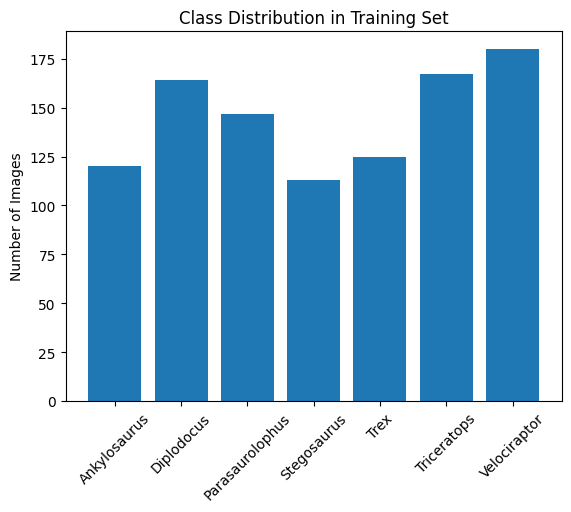

In [96]:
import matplotlib.pyplot as plt
import numpy as np

class_counts = {}
for images, labels in train_ds.unbatch():
    label = np.argmax(labels.numpy())
    class_counts[label] = class_counts.get(label, 0) + 1

classes = [class_names[k] for k in sorted(class_counts.keys())]
counts = [class_counts[k] for k in sorted(class_counts.keys())]

plt.bar(classes, counts)
plt.xticks(rotation=45)
plt.title("Class Distribution in Training Set")
plt.ylabel("Number of Images")
plt.show()

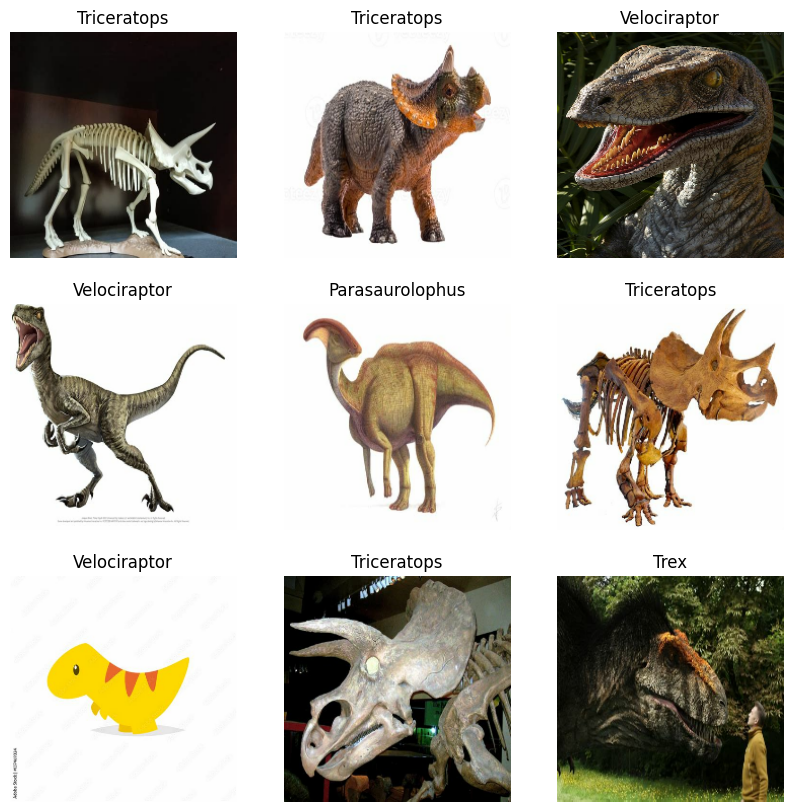

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])
        plt.axis("off")


### Image Shape

In [98]:
for image_batch, label_batch in train_ds.take(1):
    print("Image shape:", image_batch.shape)
    print("Label shape:", label_batch.shape)
    print("Image dtype:", image_batch.dtype)

Image shape: (64, 224, 224, 3)
Label shape: (64, 7)
Image dtype: <dtype: 'float32'>


# Data Preprocessing & Augmentation

### Apply ResNetV2 preprocessing

In [99]:
train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
validation_ds = validation_ds.map(lambda x, y: (preprocess_input(x), y), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda x: preprocess_input(x), num_parallel_calls=AUTOTUNE)

### Data augmentation layer

In [100]:

from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),            # Randomly flip images
    layers.RandomRotation(RANDOM_ROTATION),                 # Randomly rotate a bit
    layers.RandomZoom(RANDOM_ZOOM),                     # Slight zoom
    layers.RandomContrast(RANDOM_CONTRAST),                 # Adjust contrast
], name="data_augmentation")

### Load ResNet50V2 model + freeze the layers

In [101]:
from tensorflow.keras.applications import ResNet50V2

base_model_resnet = ResNet50V2(input_shape=(IMAGE_SIZE_2, IMAGE_SIZE_2, 3),
                             include_top=False,
                             weights='imagenet',
                             )
base_model_resnet.trainable = False

### Create the Model

In [102]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

model_resnet = Sequential([
    data_augmentation, # apply our augmentation layer from above
    base_model_resnet,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(7, activation='softmax')
])

### Learning scheduler exponential decay

In [103]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=INITIAL_LEARNING_RATE,
    decay_steps=DECAY_STEPS,
    decay_rate=DECAY_RATE,
    staircase=STAIRCASE
)
optimizer = Adam(learning_rate=lr_schedule)

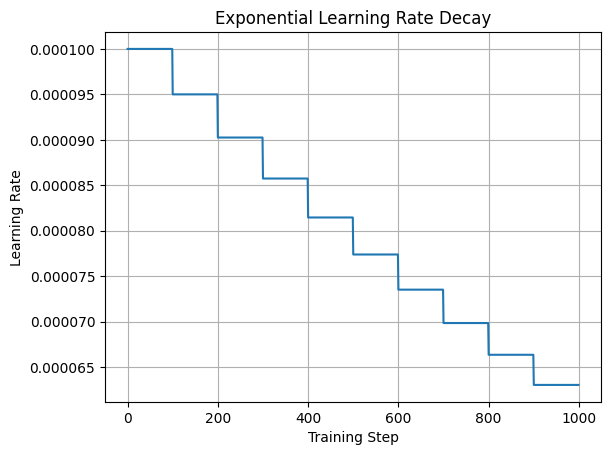

In [104]:
import matplotlib.pyplot as plt

steps = range(1000)
lrs = [lr_schedule(step).numpy() for step in steps]
plt.plot(steps, lrs)
plt.title("Exponential Learning Rate Decay")
plt.xlabel("Training Step")
plt.ylabel("Learning Rate")
plt.grid(True)
plt.show()

### Compile the model

In [105]:
model_resnet.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Fit the Model to the training data

In [106]:
history_resnet = model_resnet.fit(train_ds,
                           validation_data=validation_ds,
                           batch_size=batch_size,
                           epochs=MAX_EPOCH_RUN_1,
                           callbacks=[tensorboard_callback] #tensorboard --logdir=./logs
)

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 48s 2s/step - accuracy: 0.1991 - loss: 2.2545 - val_accuracy: 0.2174 - val_loss: 1.9592
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 36s 2s/step - accuracy: 0.3110 - loss: 1.7558 - val_accuracy: 0.4269 - val_loss: 1.6075
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 38s 2s/step - accuracy: 0.4492 - loss: 1.4908 - val_accuracy: 0.5138 - val_loss: 1.4246
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5200 - loss: 1.3364 - val_accuracy: 0.5652 - val_loss: 1.2392
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.5406 - loss: 1.2252 - val_accuracy: 0.6047 - val_loss: 1.1244
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6355 - loss: 1.0715 - val_accuracy: 0.6285 - val_loss: 1.0697
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6091 - loss: 1.0495 - val_accuracy: 0.6364 - val_loss: 0.9901
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 37s 2s/step - accuracy: 0.6673 - loss: 0.9620 - val_accuracy: 0.6719 - val_loss: 0.9308


## Plot the Loss curves

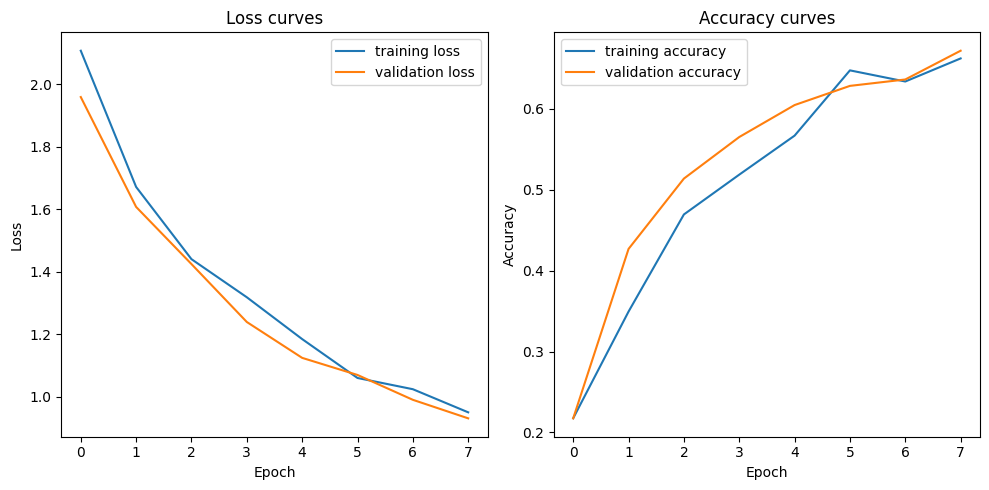

In [107]:
def plotLosses(history):
  # Create a figure and a grid of subplots with a single call
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
  # Plot the loss curves on the first subplot
  ax1.plot(history.history['loss'], label='training loss')
  ax1.plot(history.history['val_loss'], label='validation loss')
  ax1.set_title('Loss curves')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.legend()
  # Plot the accuracy curves on the second subplot
  ax2.plot(history.history['accuracy'], label='training accuracy')
  ax2.plot(history.history['val_accuracy'], label='validation accuracy')
  ax2.set_title('Accuracy curves')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.legend()
  # Adjust the spacing between subplots
  fig.tight_layout()
  # Show the figure
  plt.show()

plotLosses(history_resnet)


## Fine tuning the model

### unfreeze all layers and define a range from where to to train

In [108]:
base_model_resnet.trainable = True
fine_tune_at = FINE_TUNE_AT 

### freeze all layers before the mark

In [109]:
for layer in base_model_resnet.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model with a lower learning rate

In [110]:
model_resnet.compile(optimizer=Adam(1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Fit the model again

In [111]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history_finetuned = model_resnet.fit(train_ds,
                 validation_data=validation_ds,
                 epochs=MAX_EPOCH_RUN_2,
                 #callbacks=[early_stop]
                 )

Epoch 1/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 84s 4s/step - accuracy: 0.5549 - loss: 1.3244 - val_accuracy: 0.7154 - val_loss: 0.8809
Epoch 2/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.5929 - loss: 1.1735 - val_accuracy: 0.7194 - val_loss: 0.8231
Epoch 3/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.6333 - loss: 1.0942 - val_accuracy: 0.7233 - val_loss: 0.7752
Epoch 4/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.7074 - loss: 0.9781 - val_accuracy: 0.7470 - val_loss: 0.7327
Epoch 5/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.7366 - loss: 0.8944 - val_accuracy: 0.7826 - val_loss: 0.7066
Epoch 6/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 76s 5s/step - accuracy: 0.7760 - loss: 0.8010 - val_accuracy: 0.7905 - val_loss: 0.6627
Epoch 7/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 77s 5s/step - accuracy: 0.7660 - loss: 0.7939 - val_accuracy: 0.7984 - val_loss: 0.6313
Epoch 8/8
16/16 ━━━━━━━━━━━━━━━━━━━━ 74s 5s/step - accuracy: 0.8078 - loss: 0.7304 - val_accuracy: 0.8063 - val_loss: 0.6053


### Plot the loss curves for our fine tuned model

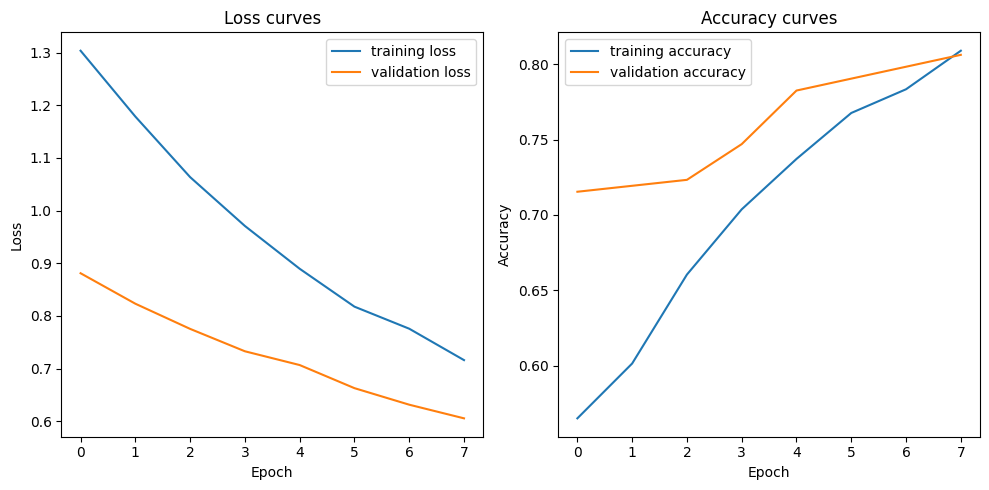

In [112]:
plotLosses(history_finetuned)

## Create the Cunfusion Matrix

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 1s/step 
Validation accuracy: 0.81


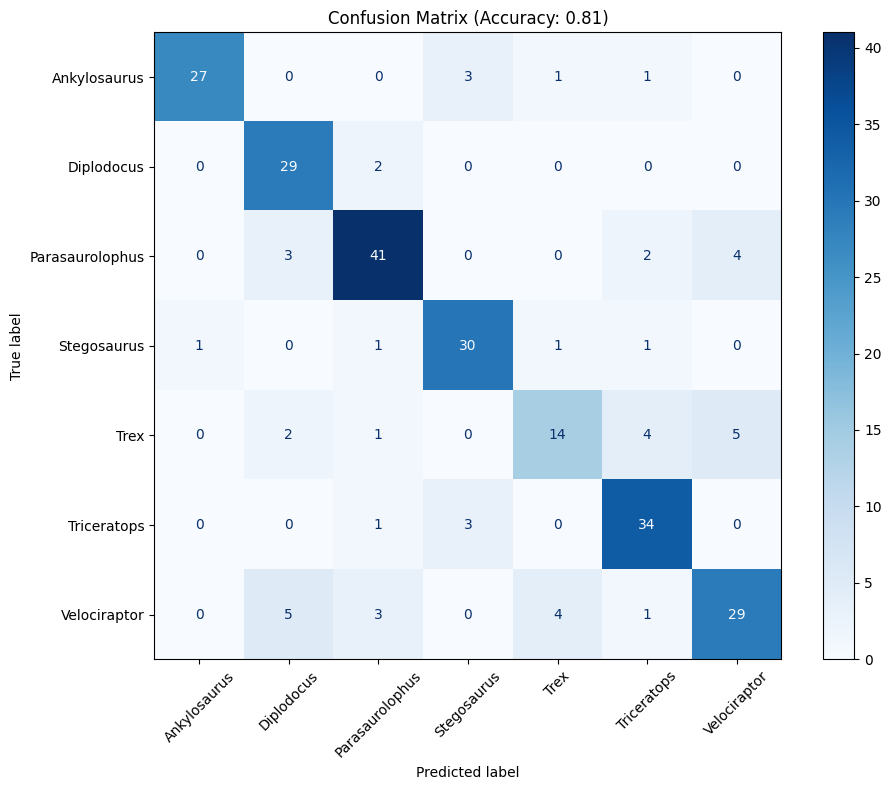

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score

X_val = []
y_val = []

for images, labels in validation_ds:
    X_val.append(images.numpy())
    y_val.append(labels.numpy())

X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)
y_val_labels = np.argmax(y_val, axis=1)  # convert one-hot to class indices

# Predict classes on validation images
predictions = model_resnet.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)

# Calculate accuracy
accuracy = accuracy_score(y_val_labels, predicted_classes)
print(f"Validation accuracy: {accuracy:.2f}")

# Compute confusion matrix
cm = confusion_matrix(y_val_labels, predicted_classes)

# Plot confusion matrix with clearer display
fig, ax = plt.subplots(figsize=(10, 8))  # bigger figure
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, ax=ax, xticks_rotation=45)  # rotate x labels
plt.title(f"Confusion Matrix (Accuracy: {accuracy:.2f})")
plt.tight_layout()  # fix clipping of labels
plt.show()

# Prediction on test data

In [114]:
import pandas as pd
import os

# Class names and corresponding numerical labels (0 - 6)
class_names = ['Ankylosaurus', 'Diplodocus', 'Parasaurolophus', 'Stegosaurus', 
               'Tyrannosaurus Rex', 'Triceratops', 'Velociraptor']
class_to_label = {name: index for index, name in enumerate(class_names)}

# Generate predictions for the entire test dataset
predictions = model_resnet.predict(test_ds)

# Get the predicted class indices (highest probability for each image)
predicted_class_indices = np.argmax(predictions, axis=1)

image_files = sorted(os.listdir("test/test"))

# Strip extensions and convert to int if needed (for numeric ID)
image_ids = [int(os.path.splitext(f)[0]) for f in image_files]

# Create a DataFrame with a simple index (1, 2, 3, ...) and the predicted label (numerical)
df = pd.DataFrame({
    'id': image_ids,
    'label': predicted_class_indices  # Use the predicted class indices as the label
})

df.to_csv('dino_predictions.csv', index=False, sep=',')

print("Predictions saved to dino_predictions.csv")



5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 2s/step
Predictions saved to dino_predictions.csv


## Wrong predictions

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 893ms/step


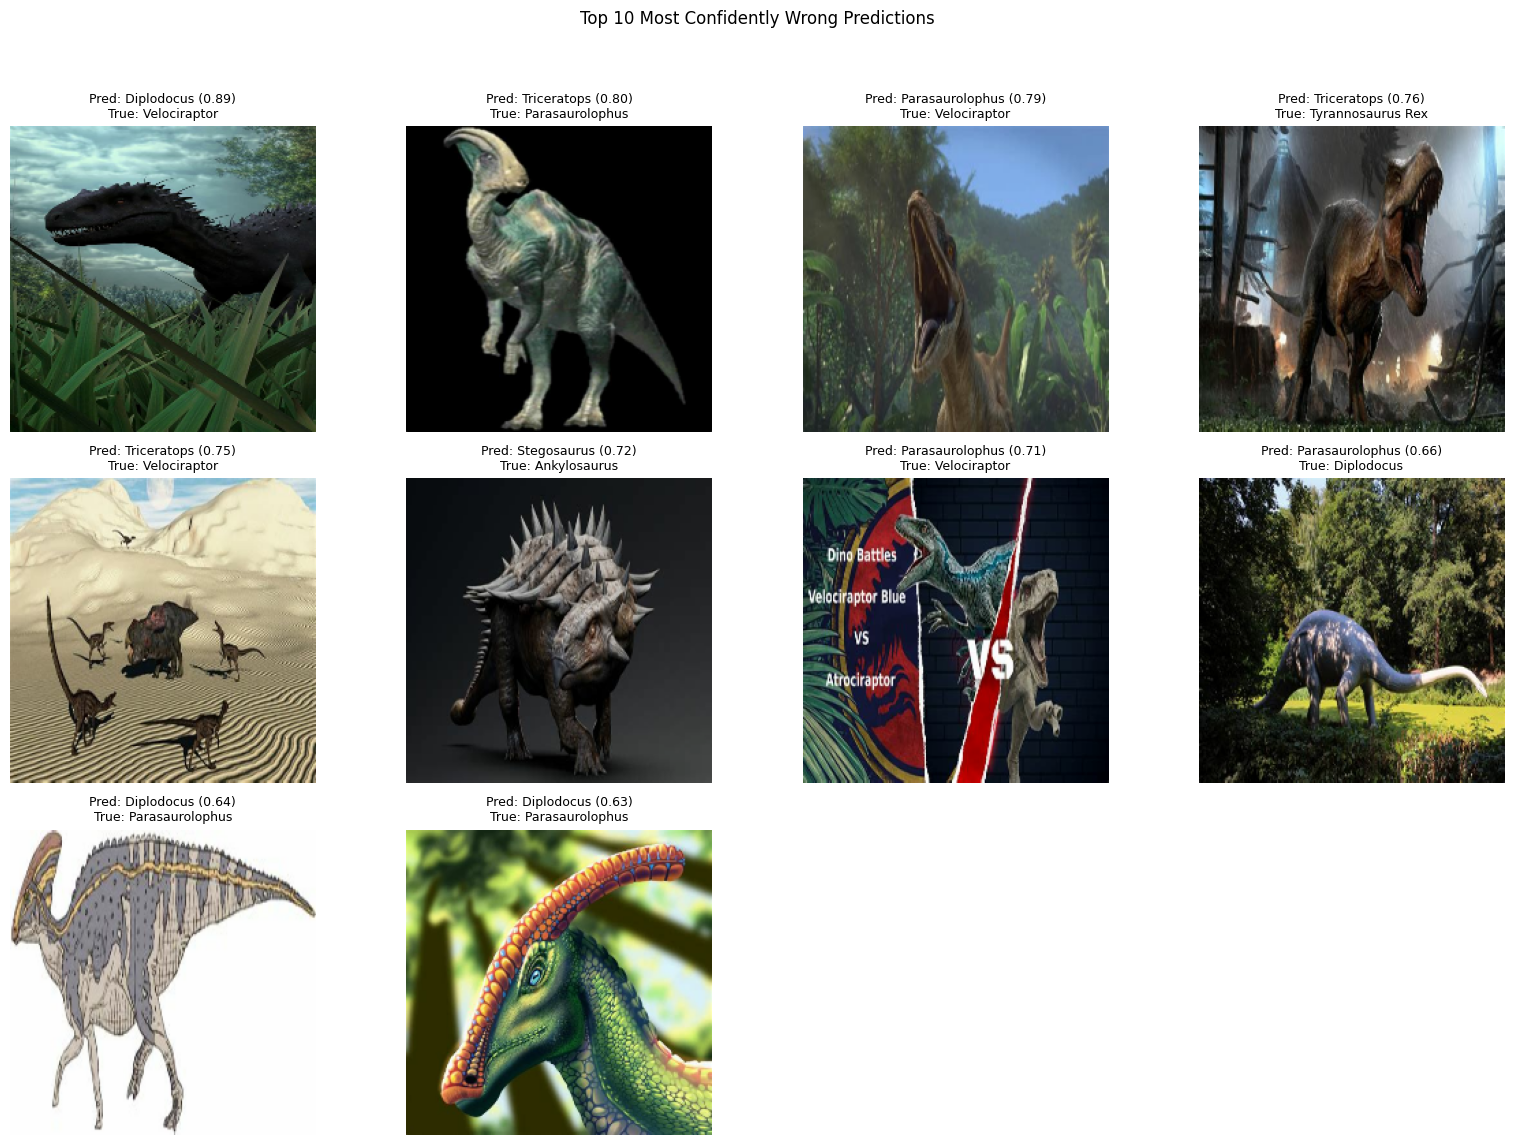

In [119]:
# Predict on validation set (which is preprocessed using preprocess_input)
predictions = model_resnet.predict(X_val)
predicted_classes = np.argmax(predictions, axis=1)
errors = predicted_classes != y_val_labels

# Get the wrong predictions and their data
wrong_images = X_val[errors]  # These are in [-1, 1] because of preprocess_input
wrong_preds = predictions[errors]
wrong_true_labels = y_val_labels[errors]
wrong_pred_classes = predicted_classes[errors]

# Calculate the confidence
confidences = np.max(wrong_preds, axis=1)

# Sort by highest wrong confidence
sorted_indices = np.argsort(-confidences)

# Number of images to show
top_n = 10
cols = 4
rows = int(np.ceil(top_n / cols))

plt.figure(figsize=(cols * 4, rows * 4))
for i in range(min(top_n, len(wrong_images))):
    idx = sorted_indices[i]
    img = wrong_images[idx]

    # ✅ Fix for ResNetV2 preprocessing: [-1, 1] → [0, 255]
    img = ((img + 1.0) * 127.5).astype(np.uint8)

    plt.subplot(rows, cols, i + 1)
    plt.imshow(img)
    plt.title(f"Pred: {class_names[wrong_pred_classes[idx]]} ({confidences[idx]:.2f})\nTrue: {class_names[wrong_true_labels[idx]]}", fontsize=9)
    plt.axis('off')

plt.suptitle(f"Top {top_n} Most Confidently Wrong Predictions")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## GenAI Section
During this project, I utilized generative AI (specifically ChatGPT) to support various stages of my deep learning workflow. This included:

- **Understanding concepts**: I asked for clarification on terms such as `AUTOTUNE`, learning rate schedules, and how to interpret loss/accuracy curves.
- **Debugging code**: GenAI helped me identify issues like `NoneType` errors when using class names, and offered fixes to prevent them.
- **Writing and improving code**:
  - Helped structure data preprocessing pipelines.
  - Suggested ways to visualize training and validation metrics.
  - Generated a clean `plotLosses` function to track model performance.
  - Provided a template for generating prediction CSVs from test data.
- **Model tuning advice**: Guided me on:
  - Whether to train for more epochs,
  - When overfitting might be happening,
  - How to try learning rate schedules or early stopping.
- **General advice**: Helped me plan next steps, evaluate training results, and reflect on model performance.

This assistance allowed me to better understand the steps in building and evaluating a deep learning model, and provided faster, clearer paths through common ML tasks.

---

**Note**: While the AI provided suggestions, all code was reviewed, adapted, and tested by me before inclusion.
